In [1]:
!pip install spacy
!python -m spacy download en_core_web_sm

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import spacy
import functools
import numpy as np
import pandas as pd
import os
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

import random

In [3]:
def mask(sentence: str, to_mask) -> str:
    nlp = spacy.load('en_core_web_sm')
    token_list = nlp(sentence)
    token_list = list(
        map(
            lambda token: '[Mask]' if to_mask(token) else token.text,
            token_list
        )
    )
    res = functools.reduce(
        lambda a, b: a + ' ' + b,
        token_list
    )
    return res

In [4]:
def count_by_predicate(sentence: str, to_mask) -> str:
    nlp = spacy.load('en_core_web_sm')
    token_list = nlp(sentence)
    count = 0
    for token in token_list:
        if(to_mask(token)):
            count += 1
    return count

In [5]:
def plot_confusion_matrix(model,x_val,y_val):
    classes_name = ['fru','ang','sad','hap']
    y_pred = model.predict(x_val)
    ConfusionMatrixDisplay.from_predictions(
      list(map(lambda prediction:classes_name[prediction],y_val.argmax(axis=1))),
      list(map(lambda prediction:classes_name[prediction],y_pred.argmax(axis=1))),
      normalize='true',cmap='GnBu')
    plt.show()

In [6]:
def load_val_set(ses_num, predicate):
    data_file = os.getcwd()
    if '/' in data_file:
        delimeter = '/'
    else:
        delimeter = '\\'
    data_file = data_file.split(delimeter)
    data_file[-1] = 'Data'
    path=''
    for dir in data_file:
        path += dir + delimeter
    path = path[:-1]
    path += delimeter
    df = pd.read_csv(path + 'textVideoClassification.tsv',sep='\t')
    
    x_val = []
    y_val = []

    for i, row in df.iterrows():
        text = row['text']
        label =  np.array(
            [float(row['label']=='fru'),float(row['label']=='ang'),float(row['label']=='sad'),float(row['label']=='hap' or row['label']=='exc')]
        )
        if row['session'] == 'Ses0{}'.format(ses_num):
            x_val.append(text)
            y_val.append(label)
    x_val = np.array(x_val)
    y_val = np.array(y_val)
    
    model = keras.models.load_model('BertSingleSentence-val_ses0{}'.format(ses_num))
    print('noraml validaiton data results')
    model.evaluate(x_val,y_val)
    plot_confusion_matrix(model,x_val,y_val)
    
    print('masked validation data results')
    x_val = np.array(
        list(
            map(
                lambda sentence: mask(str(sentence),predicate),
                x_val
            )
        )
    )
    model.evaluate(x_val,y_val)
    plot_confusion_matrix(model,x_val,y_val)

In [7]:
def mask_by_count_tokens(sentence: str, count):
    nlp = spacy.load('en_core_web_sm')
    token_list = nlp(sentence)
    selected = random.sample(range(len(token_list)), k=count)
    res = ''
    for i in range(len(token_list)):
        if i in selected:
            res += '[MASK] '
        else:
            res += token_list[i].text + ' '
    return res

In [8]:
def mask_random_tokens(ses_num, predicate):
    data_file = os.getcwd()
    if '/' in data_file:
        delimeter = '/'
    else:
        delimeter = '\\'
    data_file = data_file.split(delimeter)
    data_file[-1] = 'Data'
    path=''
    for dir in data_file:
        path += dir + delimeter
    path = path[:-1]
    path += delimeter
    df = pd.read_csv(path + 'textVideoClassification.tsv',sep='\t')
    
    x_val = []
    y_val = []

    for i, row in df.iterrows():
        text = row['text']
        label =  np.array(
            [float(row['label']=='fru'),float(row['label']=='ang'),float(row['label']=='sad'),float(row['label']=='hap' or row['label']=='exc')]
        )
        if row['session'] == 'Ses0{}'.format(ses_num):
            x_val.append(text)
            y_val.append(label)
    x_val = np.array(x_val)
    y_val = np.array(y_val)
    
    
    model = keras.models.load_model('BertSingleSentence-val_ses0{}'.format(ses_num))
    print('noraml validaiton data results')
    model.evaluate(x_val,y_val)
    plot_confusion_matrix(model,x_val,y_val)
    
    print('masked validation data results')
    
    count_list = []
    for i in range(len(x_val)):
        count_list.append(count_by_predicate(str(x_val[i]), predicate))
    
    for i in range(len(x_val)):
        x_val[i] = mask_by_count_tokens(str(x_val[i]), count_list[i])

    
    
    model.evaluate(x_val,y_val)
    plot_confusion_matrix(model,x_val,y_val)

# Mask All Adjectives

In [9]:
def is_adjective(token):
    return token.pos_ == 'ADJ'

-------------Ses01-----------------
noraml validaiton data results
31/31 [==============================] - 9s 275ms/step


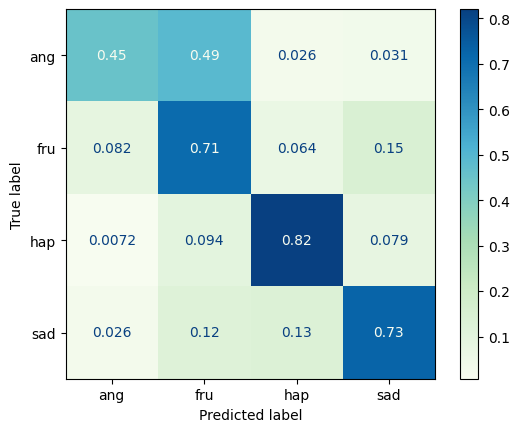

masked validation data results
31/31 [==============================] - 8s 275ms/step


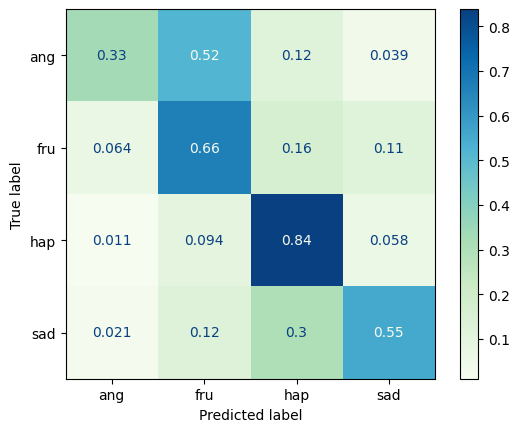

------------------------------------
-------------Ses02-----------------
noraml validaiton data results
31/31 [==============================] - 9s 276ms/step


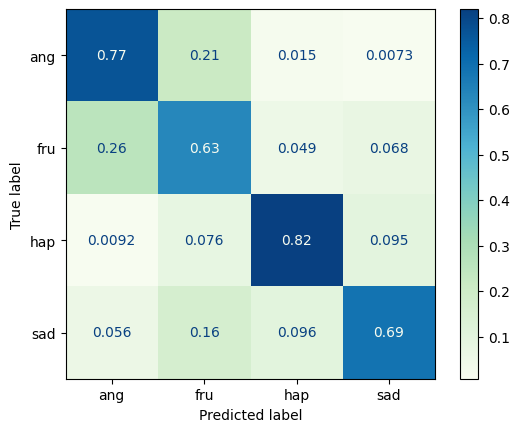

masked validation data results
31/31 [==============================] - 8s 276ms/step


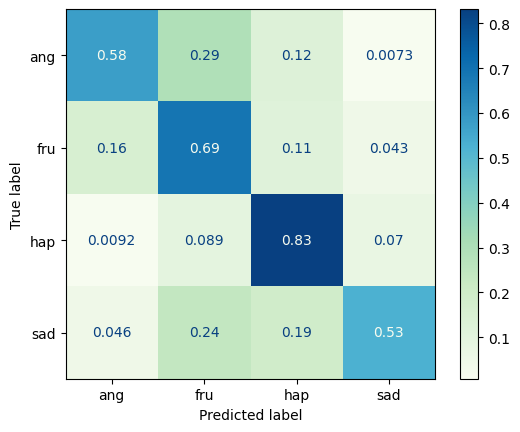

------------------------------------
-------------Ses03-----------------
noraml validaiton data results
38/38 [==============================] - 11s 275ms/step


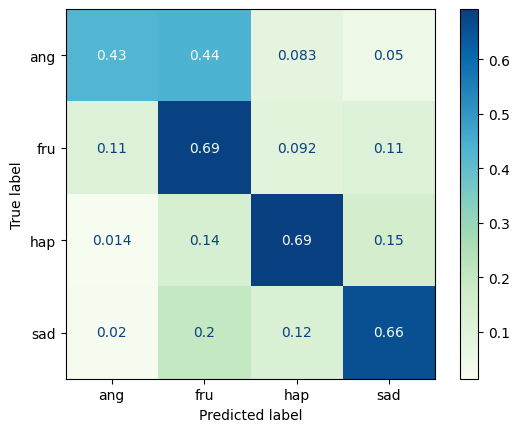

masked validation data results
38/38 [==============================] - 10s 276ms/step


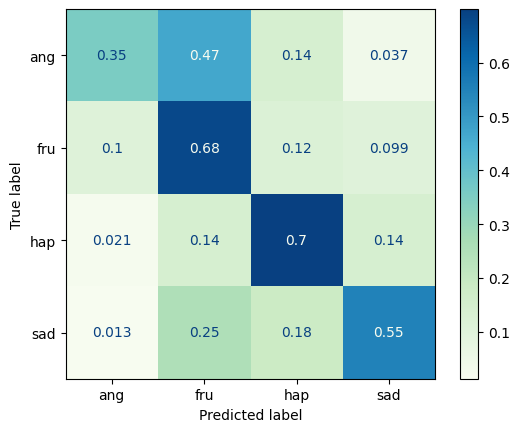

------------------------------------
-------------Ses04-----------------
noraml validaiton data results
40/40 [==============================] - 11s 275ms/step


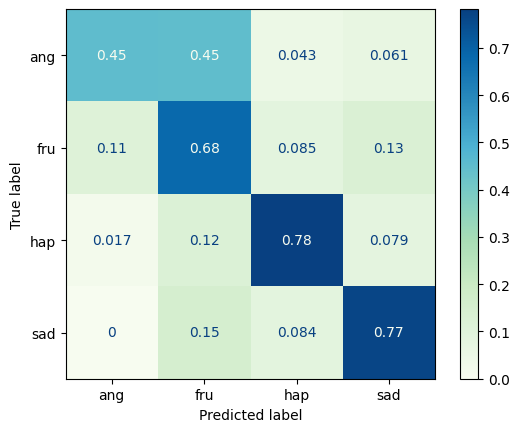

masked validation data results
40/40 [==============================] - 11s 275ms/step


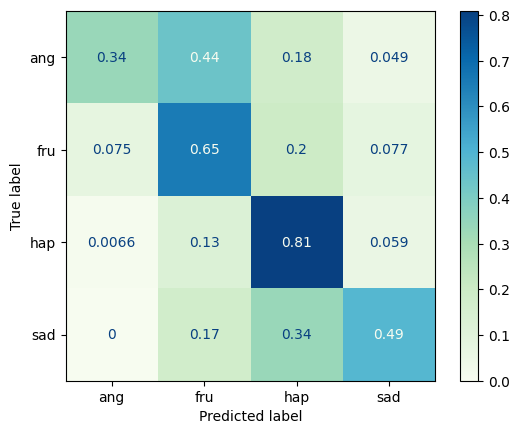

------------------------------------
-------------Ses05-----------------
noraml validaiton data results
39/39 [==============================] - 11s 275ms/step


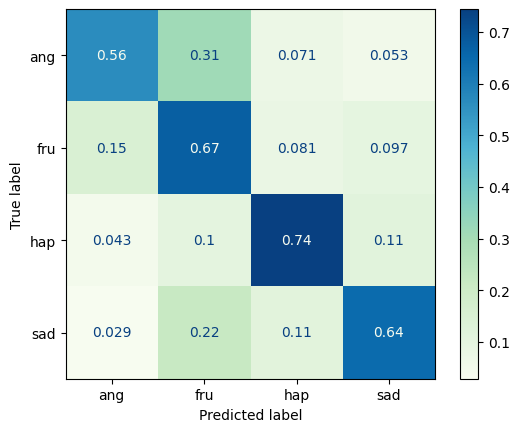

masked validation data results
39/39 [==============================] - 11s 276ms/step


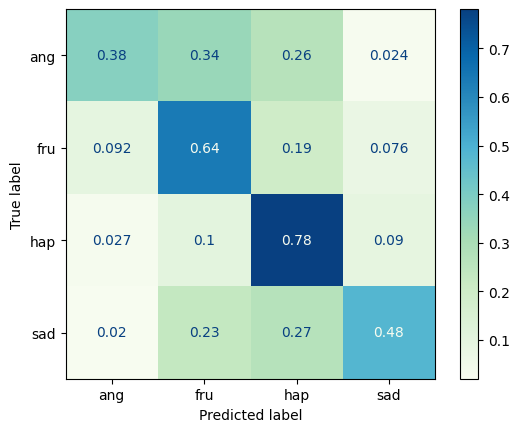

------------------------------------


In [10]:
for i in range(1,6):
    print('-------------Ses0{}-----------------'.format(i))
    load_val_set(i,is_adjective)
    print('------------------------------------')
    

### Mask random tokens

---------------Ses01------------------
noraml validaiton data results
31/31 [==============================] - 9s 275ms/step


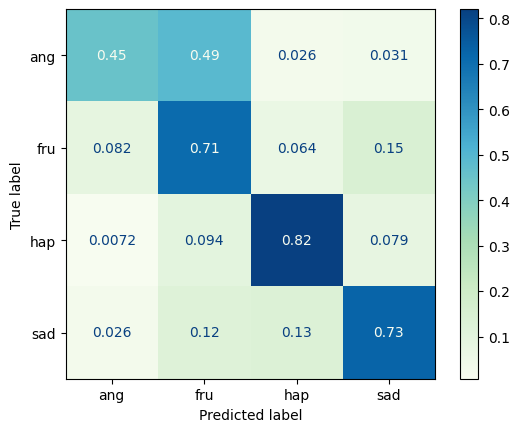

masked validation data results
31/31 [==============================] - 8s 275ms/step


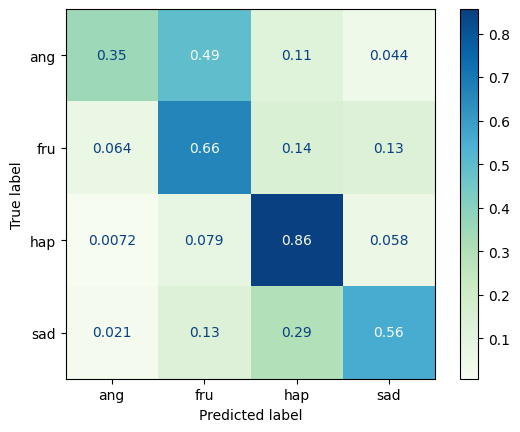

---------------Ses02------------------
noraml validaiton data results
31/31 [==============================] - 9s 276ms/step


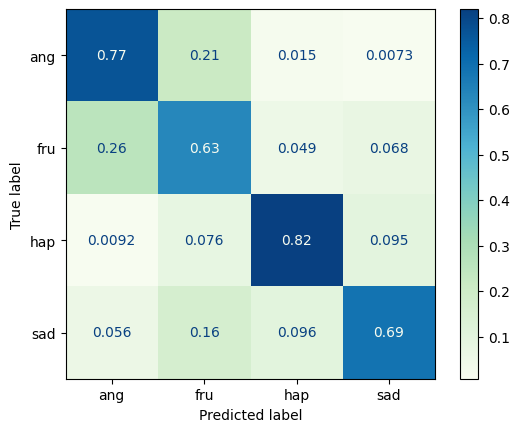

masked validation data results
31/31 [==============================] - 8s 276ms/step


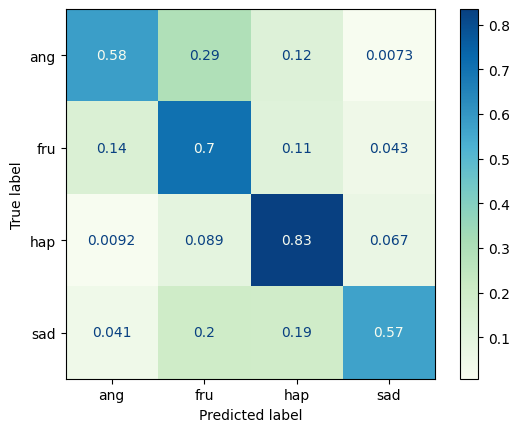

---------------Ses03------------------
noraml validaiton data results
38/38 [==============================] - 11s 275ms/step


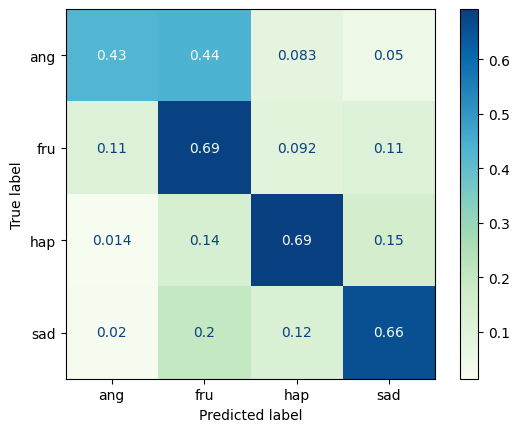

masked validation data results
38/38 [==============================] - 10s 275ms/step


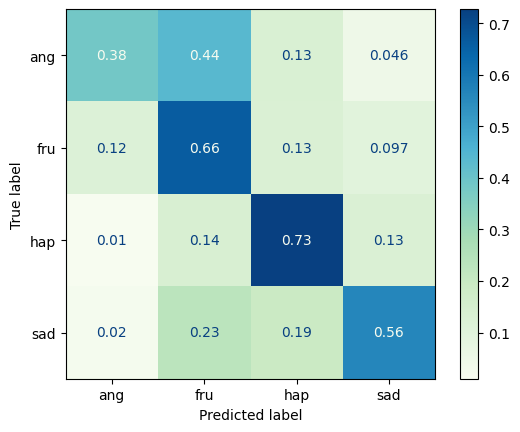

---------------Ses04------------------
noraml validaiton data results
40/40 [==============================] - 12s 275ms/step


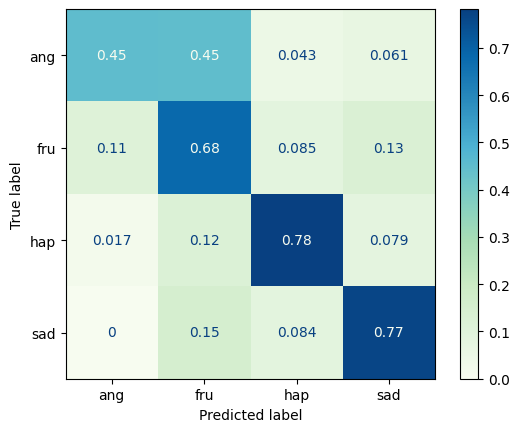

masked validation data results
40/40 [==============================] - 11s 275ms/step


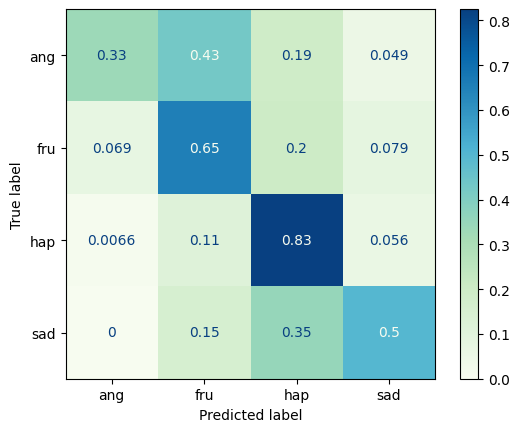

---------------Ses05------------------
noraml validaiton data results
39/39 [==============================] - 11s 275ms/step


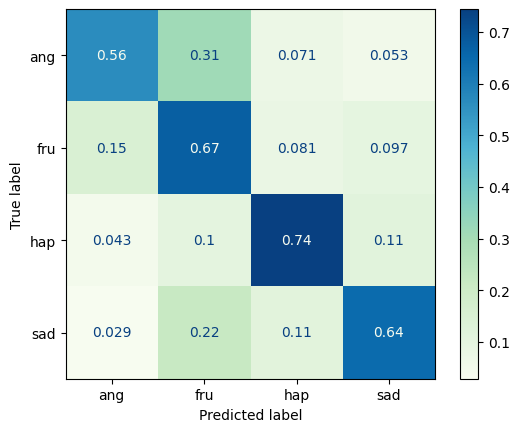

masked validation data results
39/39 [==============================] - 11s 275ms/step


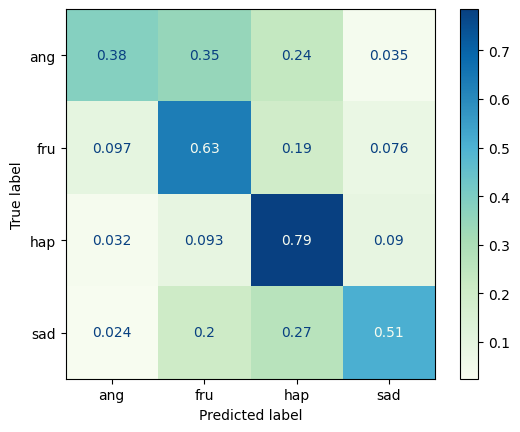

In [15]:
for i in range(1,6):
    print('---------------Ses0{}------------------'.format(i))
    mask_random_tokens(i,is_adjective)

# Mask All Nouns

In [16]:
def is_noun(token):
    return token.pos_ == 'NOUN'

-------------Ses01-----------------
noraml validaiton data results
31/31 [==============================] - 9s 275ms/step


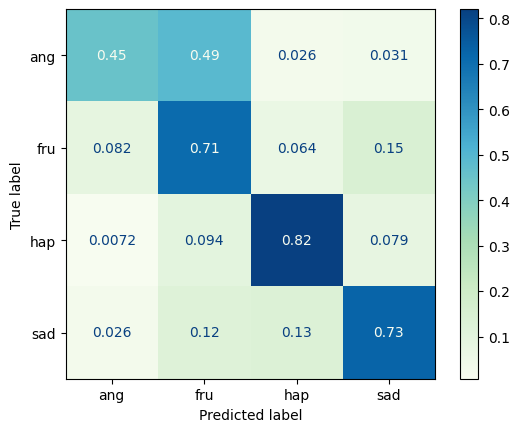

masked validation data results
31/31 [==============================] - 8s 275ms/step


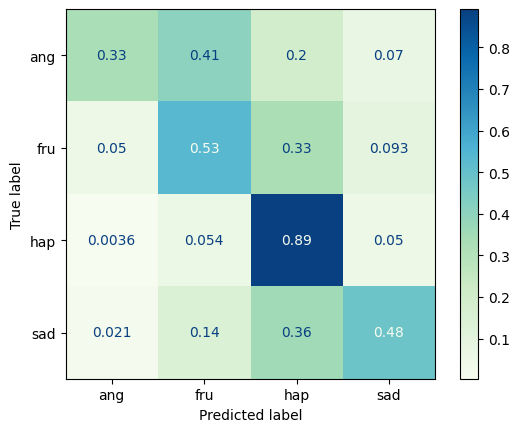

------------------------------------
-------------Ses02-----------------
noraml validaiton data results
31/31 [==============================] - 9s 276ms/step


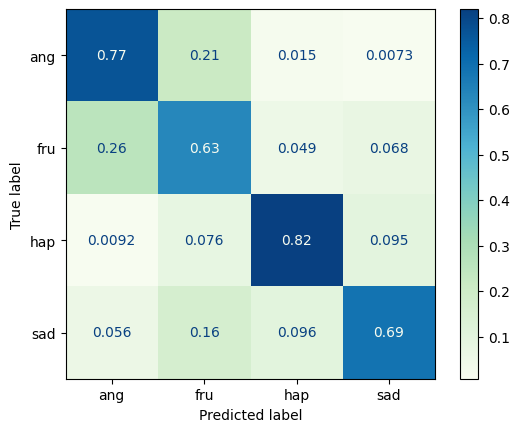

masked validation data results
31/31 [==============================] - 8s 275ms/step


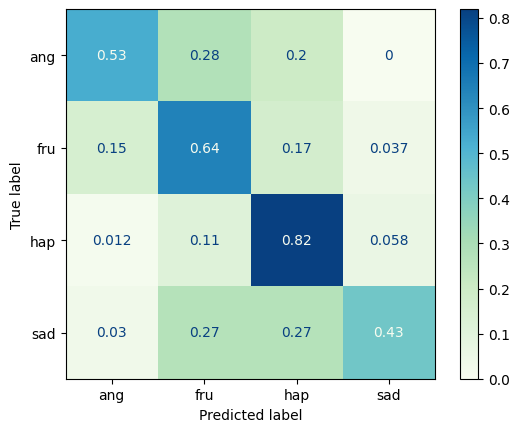

------------------------------------
-------------Ses03-----------------
noraml validaiton data results
38/38 [==============================] - 11s 276ms/step


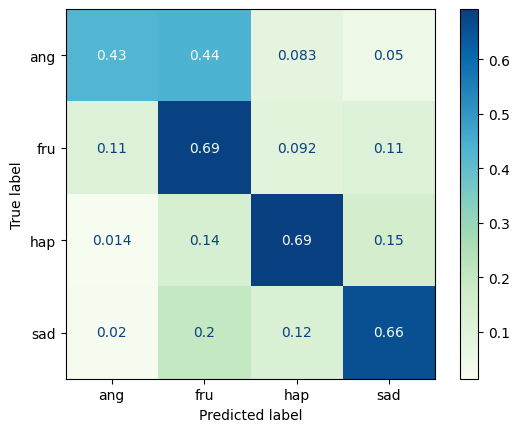

masked validation data results
38/38 [==============================] - 10s 276ms/step


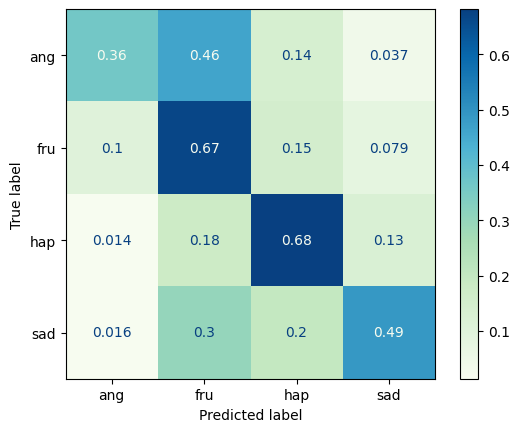

------------------------------------
-------------Ses04-----------------
noraml validaiton data results
40/40 [==============================] - 11s 275ms/step


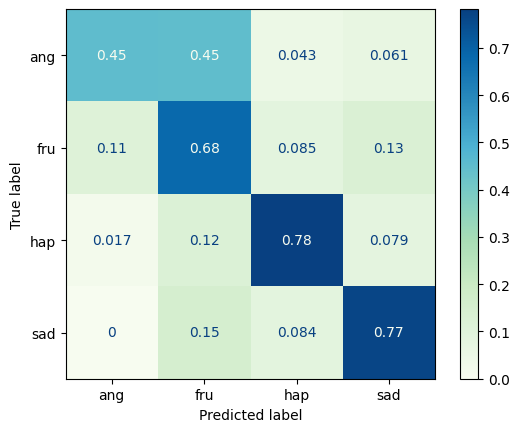

masked validation data results
40/40 [==============================] - 11s 275ms/step


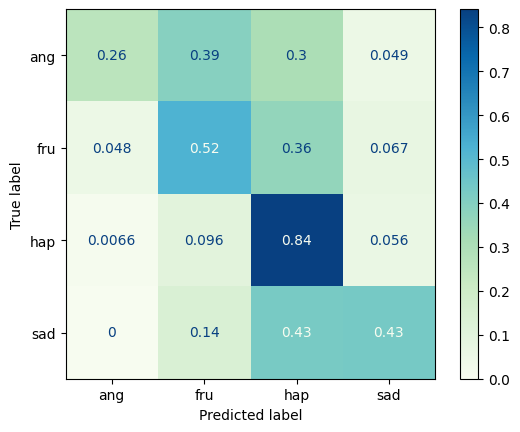

------------------------------------
-------------Ses05-----------------
noraml validaiton data results
39/39 [==============================] - 11s 275ms/step


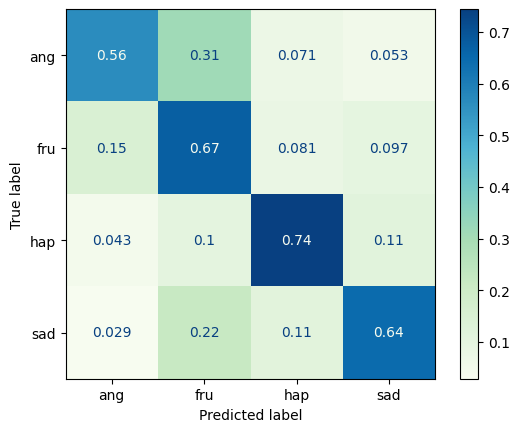

masked validation data results
39/39 [==============================] - 10s 275ms/step


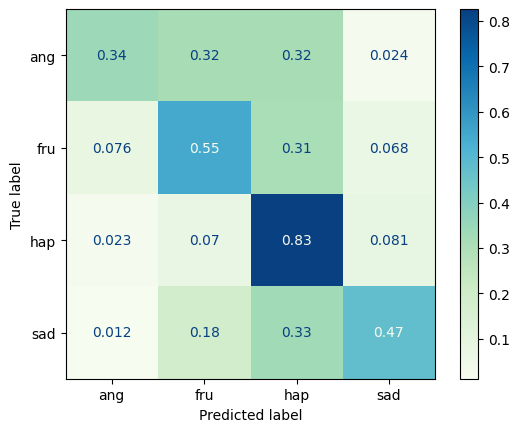

------------------------------------


In [17]:
for i in range(1,6):
    print('-------------Ses0{}-----------------'.format(i))
    load_val_set(i,is_noun)
    print('------------------------------------')
    

---------------Ses01------------------
noraml validaiton data results
31/31 [==============================] - 9s 275ms/step


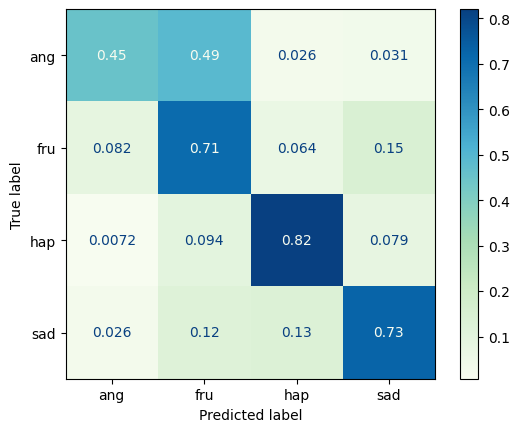

masked validation data results
31/31 [==============================] - 8s 275ms/step


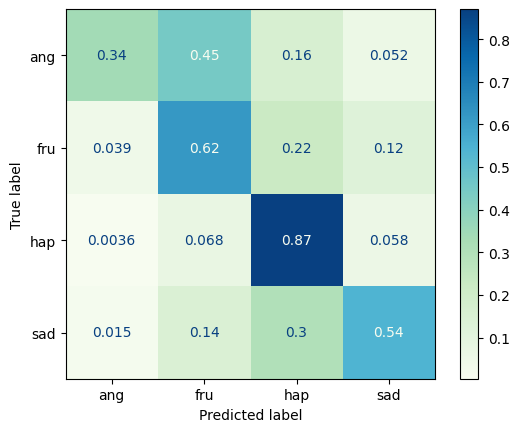

---------------Ses02------------------
noraml validaiton data results
31/31 [==============================] - 9s 275ms/step


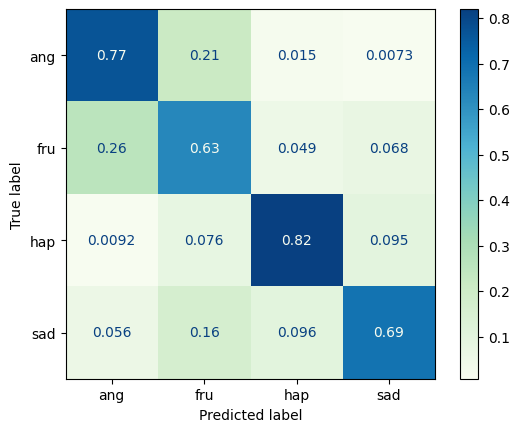

masked validation data results
31/31 [==============================] - 8s 275ms/step


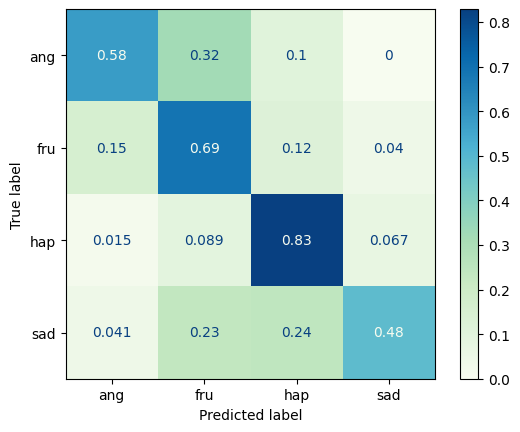

---------------Ses03------------------
noraml validaiton data results
38/38 [==============================] - 11s 275ms/step


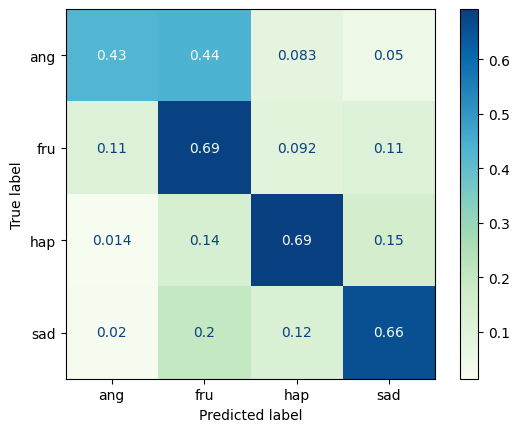

masked validation data results
38/38 [==============================] - 10s 275ms/step


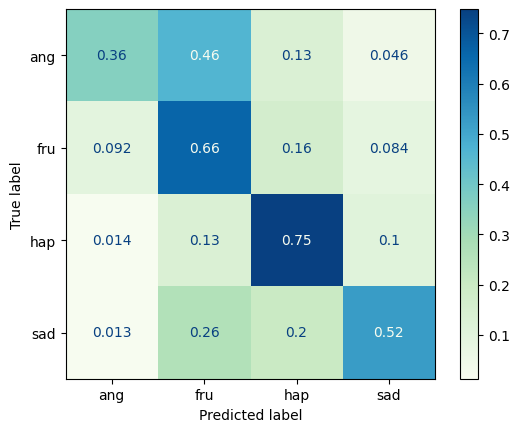

---------------Ses04------------------
noraml validaiton data results
40/40 [==============================] - 11s 275ms/step


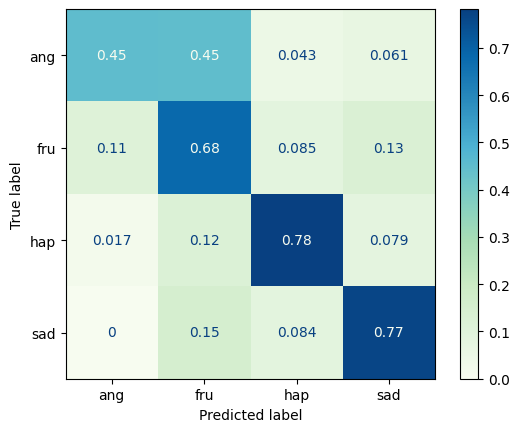

masked validation data results
40/40 [==============================] - 11s 275ms/step


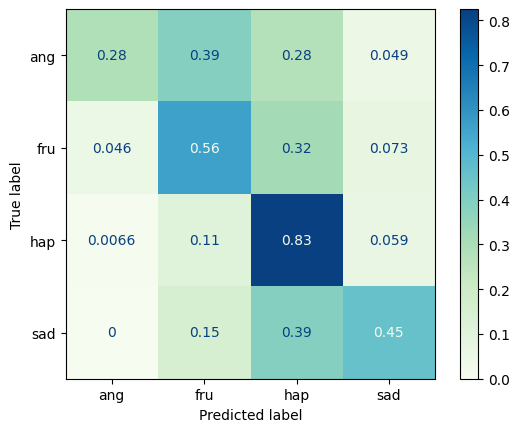

---------------Ses05------------------
noraml validaiton data results
39/39 [==============================] - 11s 275ms/step


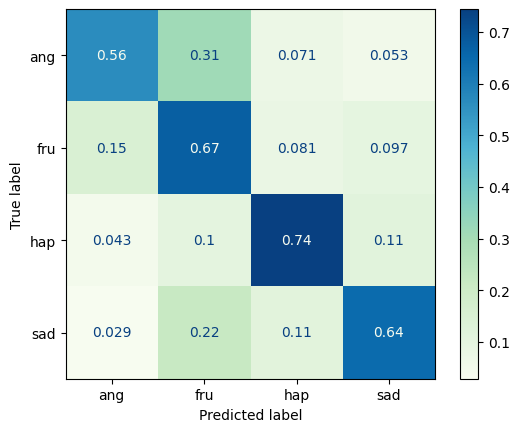

masked validation data results
39/39 [==============================] - 10s 275ms/step


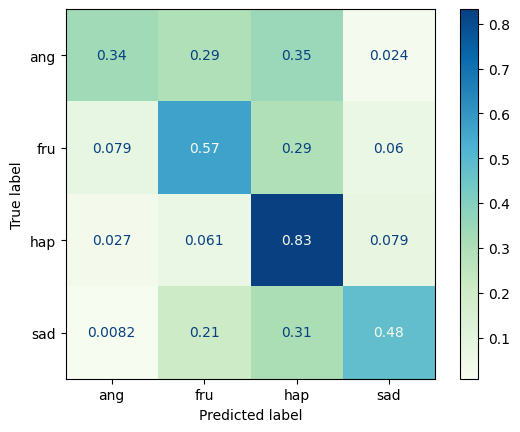

In [19]:
for i in range(1,6):
    print('---------------Ses0{}------------------'.format(i))
    mask_random_tokens(i,is_noun)